In [1]:
import torch

/home/zheyu/Anaconda/envs/robosaga/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
n_samples = 10000
buffer_watcher = torch.zeros(n_samples)
global_indices = torch.arange(n_samples)
data = torch.randn(n_samples, 10)

batch_size = 100
update_percent = 0.1

n_epochs = 11
for _ in range(n_epochs):
    global_ids = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        current_global_ids = global_ids[i:i+batch_size]
        batch_indices = torch.arange(0, batch_size) 
        update_freq = buffer_watcher[current_global_ids]
        sorted_update_freq, sorted_indices = torch.sort(update_freq)
        batch_indices = batch_indices[sorted_indices]
        current_global_ids = current_global_ids[sorted_indices]
        n_update_samples = int(batch_size * update_percent)
        buffer_watcher[current_global_ids[:n_update_samples]] += 1
    updated_sample_count = torch.sum(buffer_watcher > 0)
    print(f"Buffer watcher: {updated_sample_count/n_samples} samples seen")

Buffer watcher: 0.10000000149011612 samples seen
Buffer watcher: 0.20000000298023224 samples seen
Buffer watcher: 0.30000001192092896 samples seen
Buffer watcher: 0.4000000059604645 samples seen
Buffer watcher: 0.5 samples seen
Buffer watcher: 0.6000000238418579 samples seen
Buffer watcher: 0.699999988079071 samples seen
Buffer watcher: 0.800000011920929 samples seen
Buffer watcher: 0.8999999761581421 samples seen
Buffer watcher: 0.9889000058174133 samples seen
Buffer watcher: 1.0 samples seen


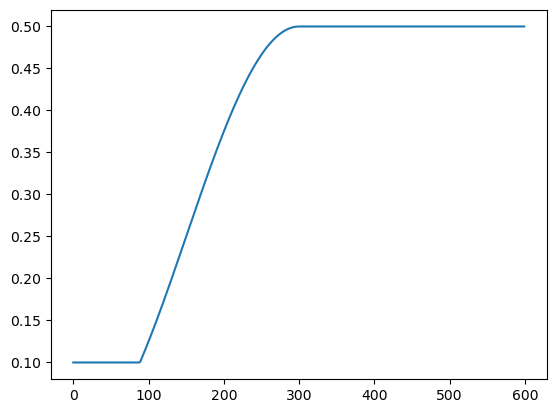

In [9]:
import numpy as np
from math import cos, pi
import matplotlib.pyplot as plt

aug_ratio = 0.5
saturation_epoch = 300
epoch_idx = np.arange(0, 600)  
update_ratio = 0.1

lambda_ = 0.5 * (1 - np.cos(epoch_idx * pi / saturation_epoch))
lambda_[epoch_idx > saturation_epoch] = 1
aug_ratio = aug_ratio * lambda_
aug_ratio[aug_ratio < update_ratio] = update_ratio

plt.plot(epoch_idx, aug_ratio)

In [ ]:
import os
from PIL import Image

def crop_and_save_as_png(image_path):
    img = Image.open(image_path)
    is_jpg = image_path.endswith('.jpg')    
    width, height = img.size
    # if width != height or is_jpg:
    min_dim = min(width, height)
    left = (width - min_dim)/2
    top = (height - min_dim)/2
    right = (width + min_dim)/2
    bottom = (height + min_dim)/2
    img = img.crop((left, top, right, bottom))
    img = img.resize((800, 800))
    image_path_new = os.path.splitext(image_path)[0] + '.png'
    img.save(image_path_new, 'PNG')
    # save n randomly cropped and rotated images
    for i in range(1, 4):
        img = img.rotate(90 * i)
        img.save(os.path.splitext(image_path)[0] + f'_{i}.png', 'PNG')
    
    
    if is_jpg:
        os.remove(image_path)

directory = '/home/zheyu/RoboSaGA/robosuite/robosuite/models/assets/textures/evaluation_textures/outdoor'
for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        crop_and_save_as_png(os.path.join(directory, filename))
        
        